##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,08
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result\\3.08"
numberOfGenerations = 150;
percolation = 0.37;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%m/%d/%Y %H:%M:%S AM\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

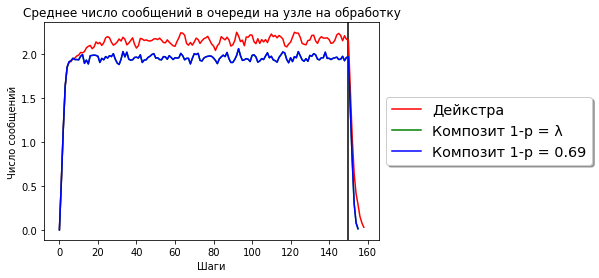

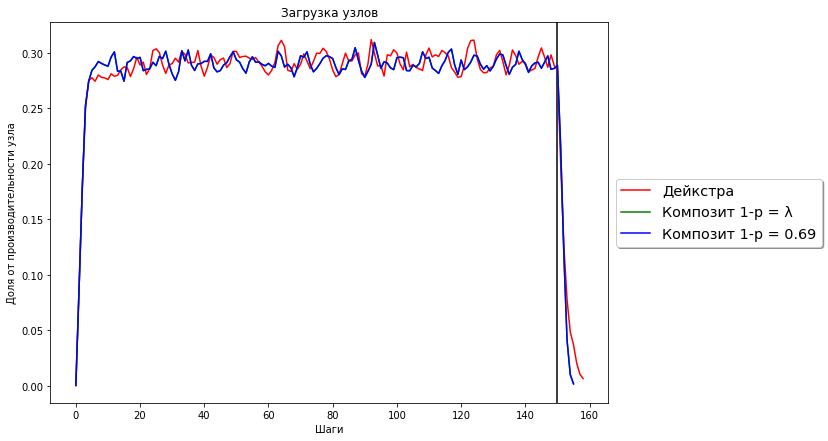

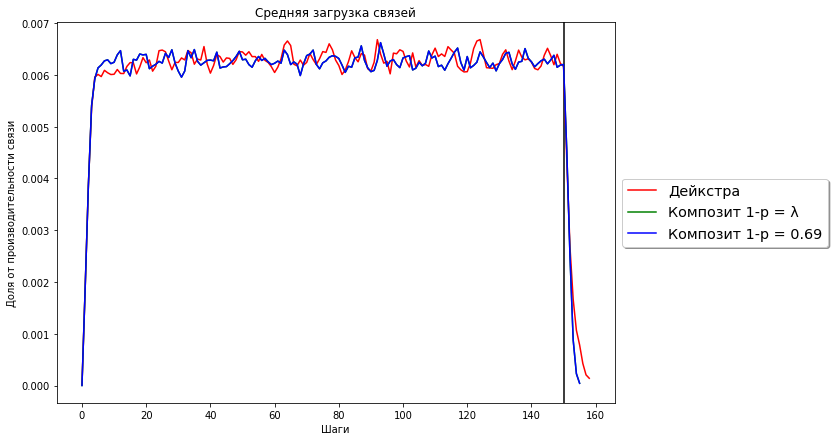

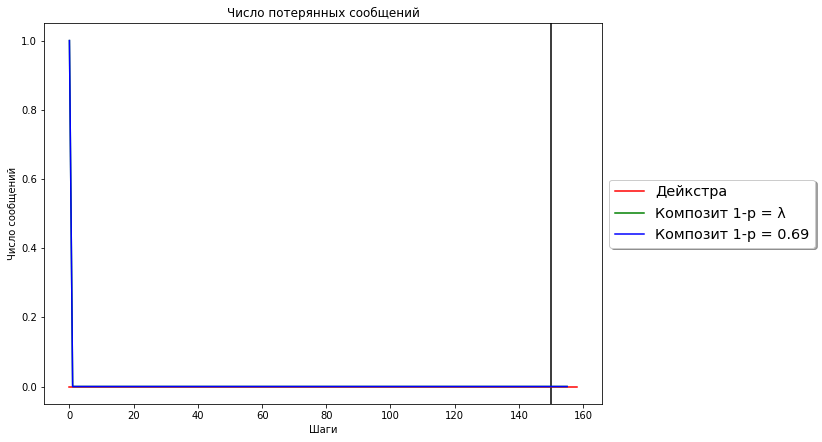

Доставлено 15001 Потеряно 0.0000% -Дейкстра
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = λ
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = 0.69


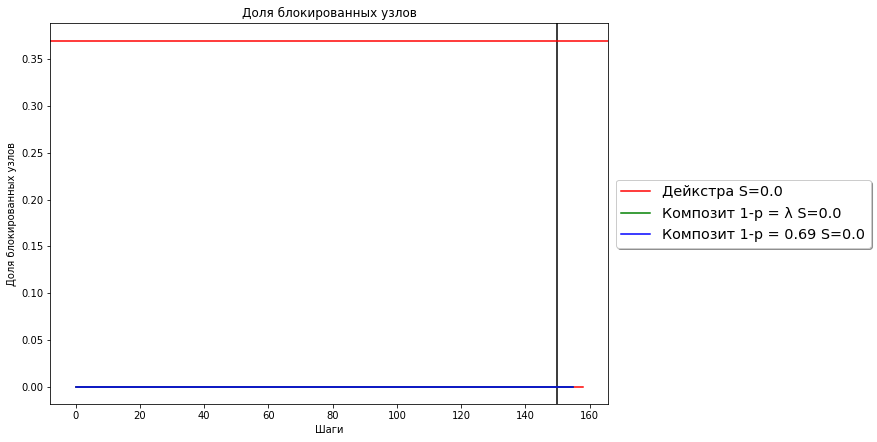

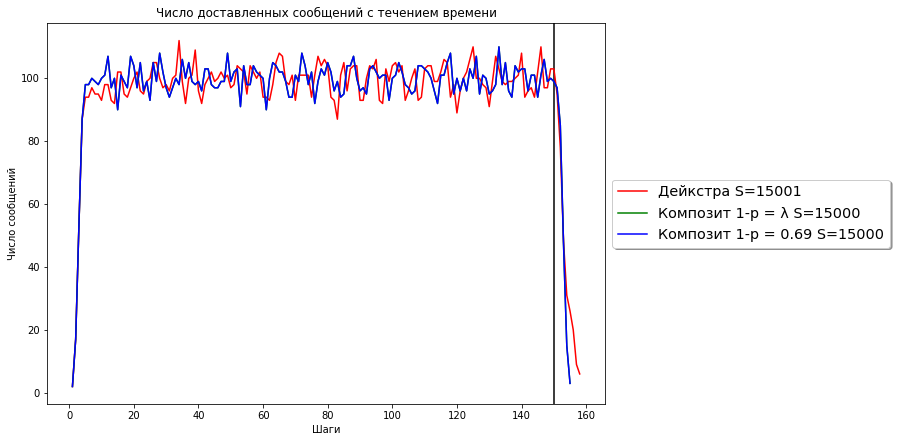

In [2]:
log_tags = [
 {"tag":  "792e3535-4ec2-480c-8bf6-ebaf9513592f", "label": "Дейкстра", "color": "red"},
 #{"tag":  "66872dd3-aad2-4a47-ad59-4de52ed29940", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "0cac83cf-7ac4-4bc4-a5dc-16e956603c14", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "9e35ffe3-a739-4a78-9ab2-aec4443d5435", "label": "Композит 1-p = 0.69", "color": "blue"},
    #  magenta red green black
]
      
quantity = 100;                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

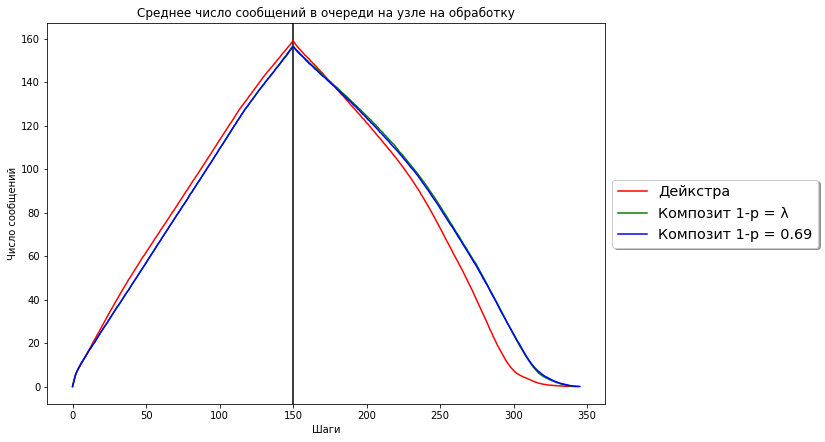

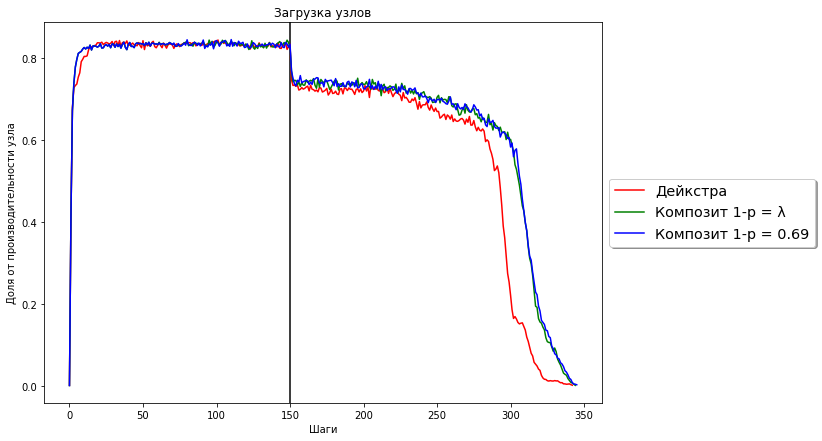

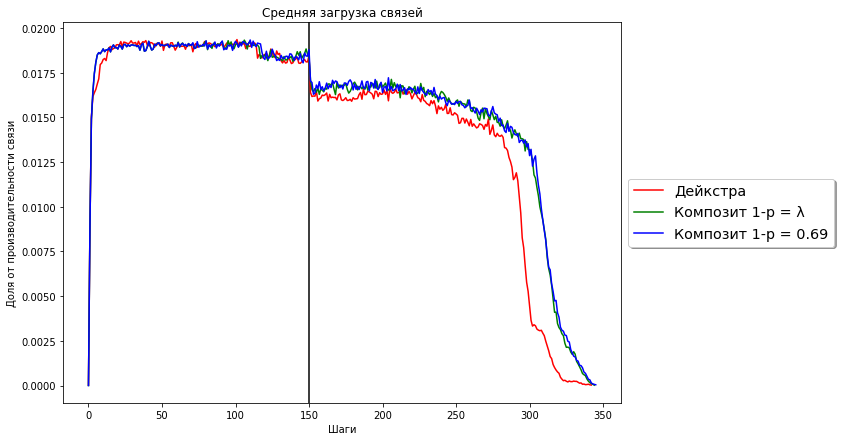

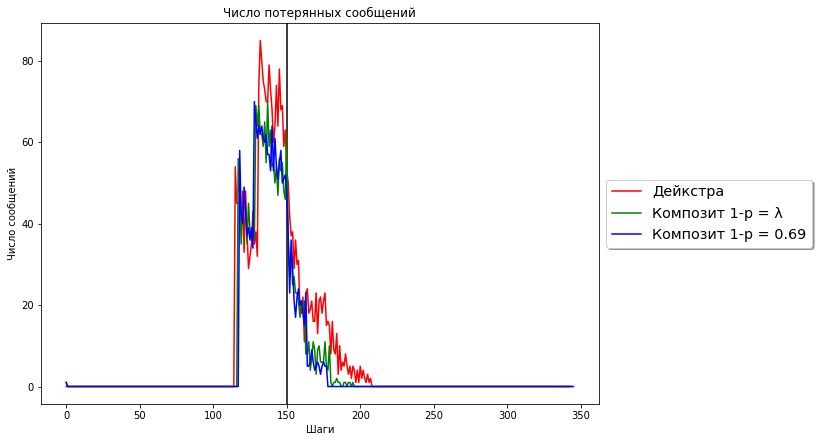

Доставлено 72136 Потеряно 3.8199% -Дейкстра
Доставлено 72791 Потеряно 2.9466% -Композит 1-p = λ
Доставлено 72869 Потеряно 2.8426% -Композит 1-p = 0.69


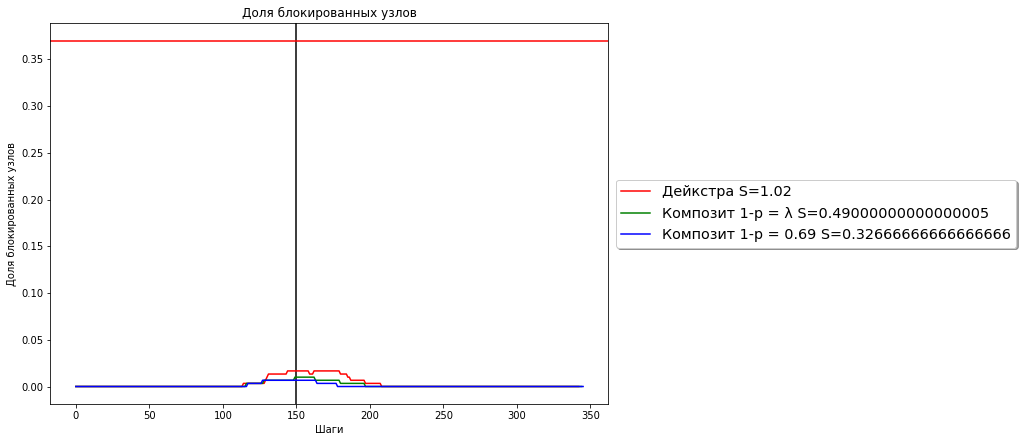

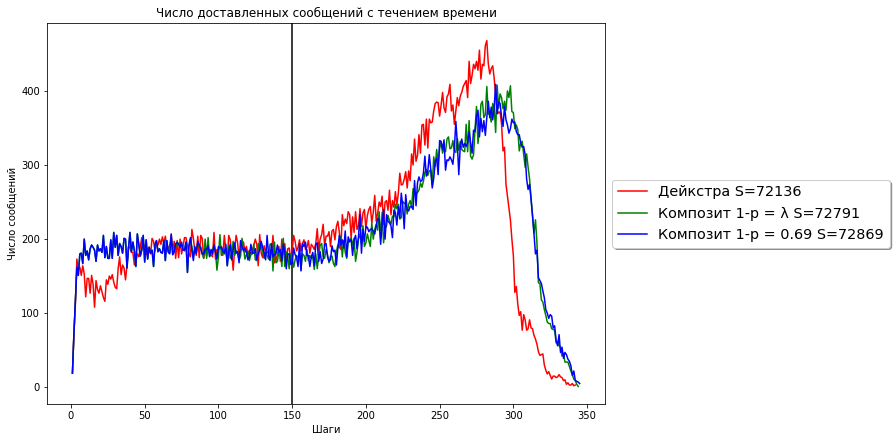

In [3]:
log_tags = [
 {"tag":  "22a74cd4-bba1-4421-b136-d0327b84afe6", "label": "Дейкстра", "color": "red"},
 #{"tag":  "d4757e03-f4de-4e75-b736-821b544dfe17", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "8f2fb1e2-b6aa-4029-bc46-c73fc77cd4dc", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "4a1c4702-e4b5-4fd2-a8a6-17e9528f083c", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

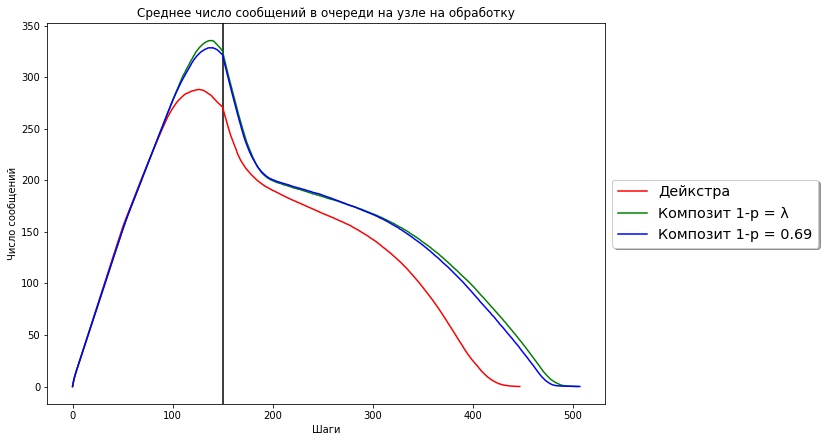

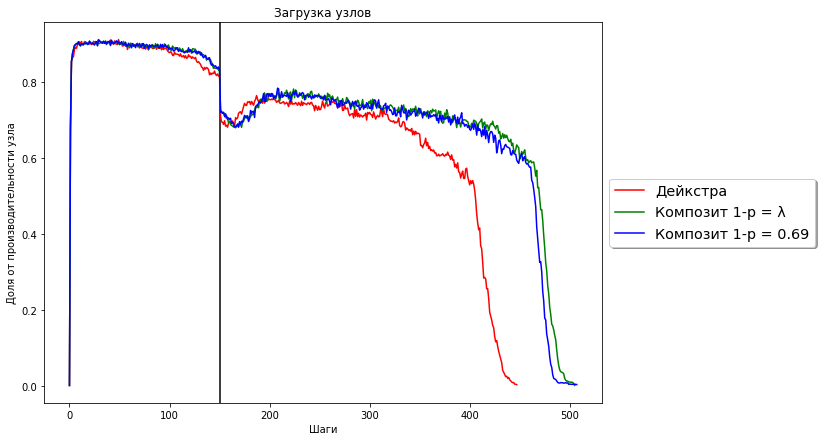

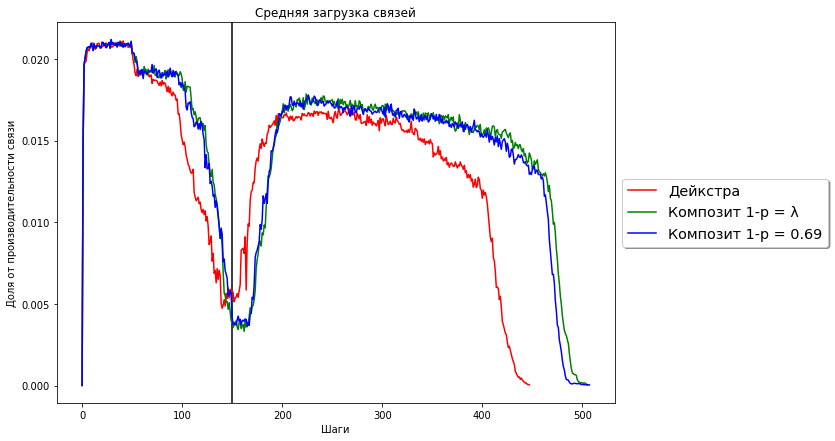

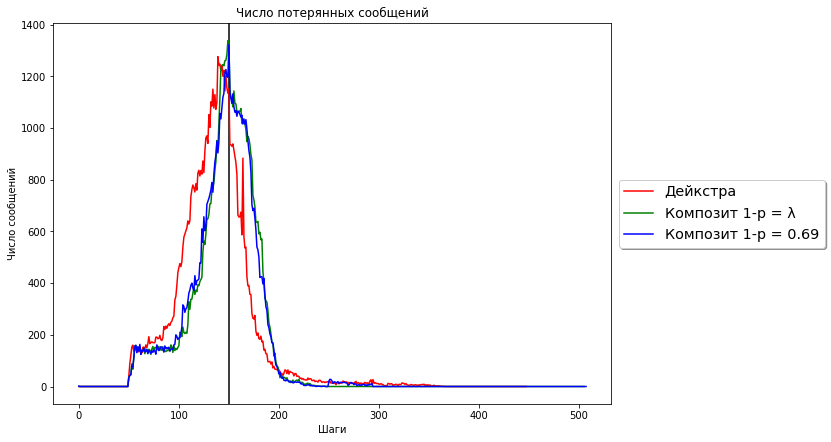

Доставлено 72586 Потеряно 51.6097% -Дейкстра
Доставлено 76377 Потеряно 49.0823% -Композит 1-p = λ
Доставлено 76514 Потеряно 48.9910% -Композит 1-p = 0.69


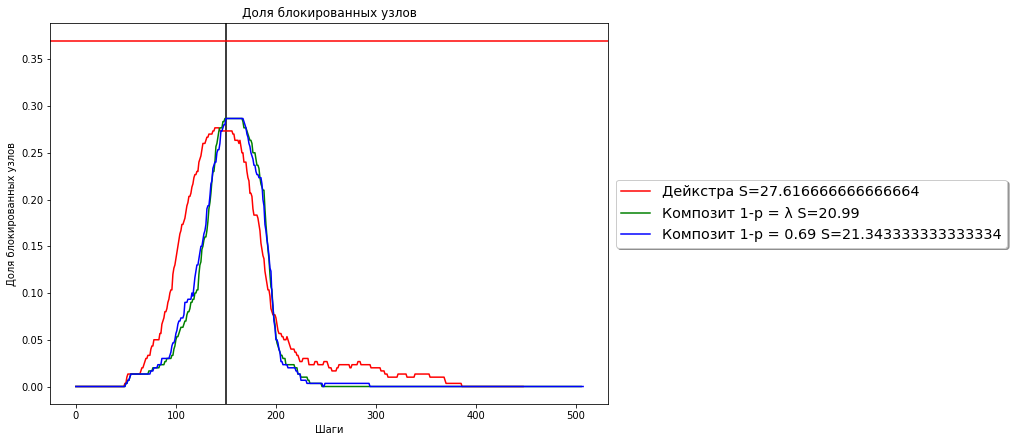

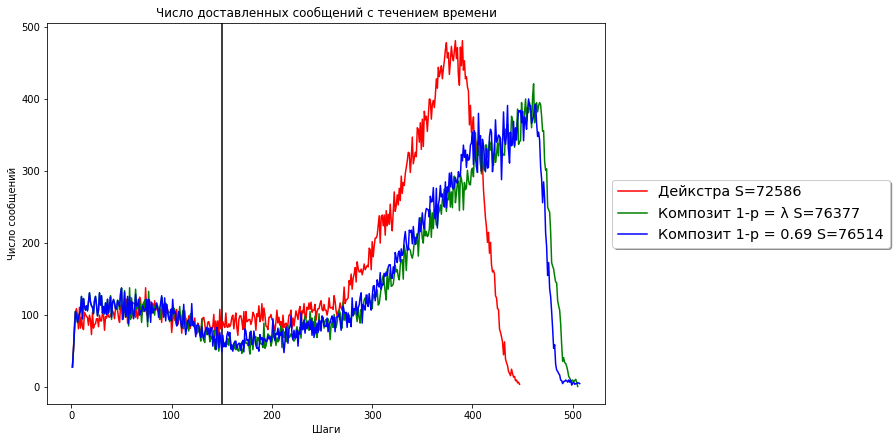

In [4]:
log_tags = [
 {"tag":  "6b566d47-9199-415a-921d-ad0578ff2851", "label": "Дейкстра", "color": "red"},
 #{"tag":  "8b06eba0-5d75-426c-98b4-25cdfe9a26fc", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "495324bf-a1fd-4601-952f-a2be7e3712b2", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "1f3ff7c0-29cb-4fdd-854c-b5497bb7c264", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

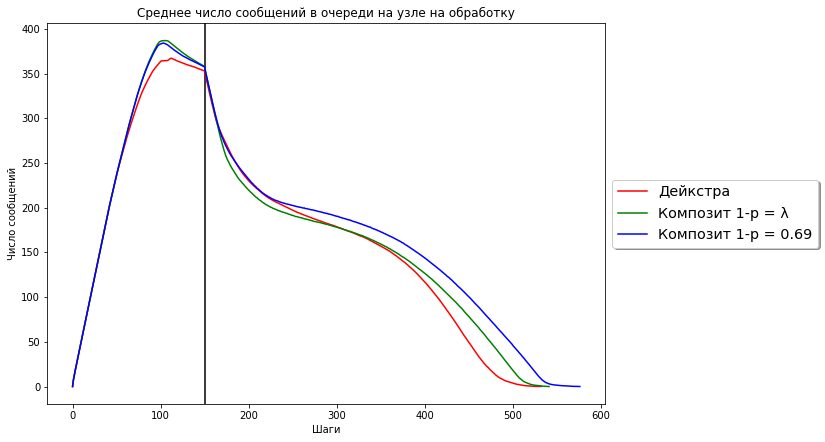

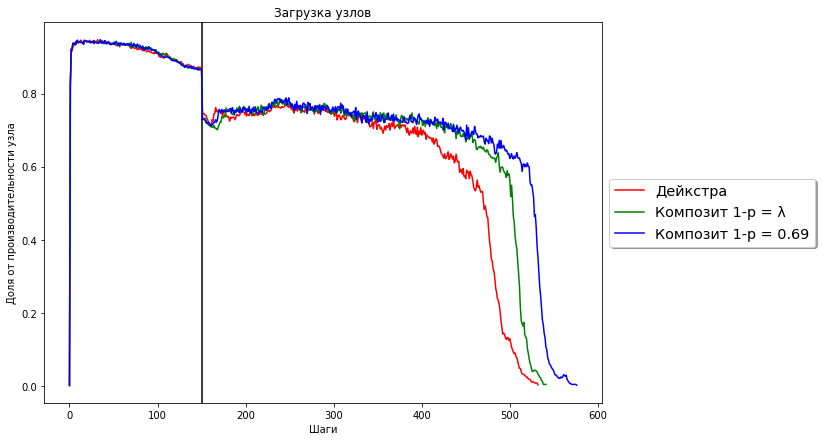

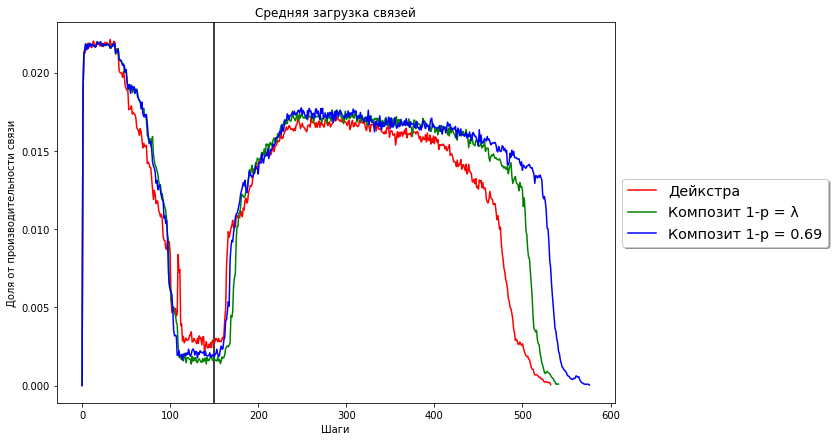

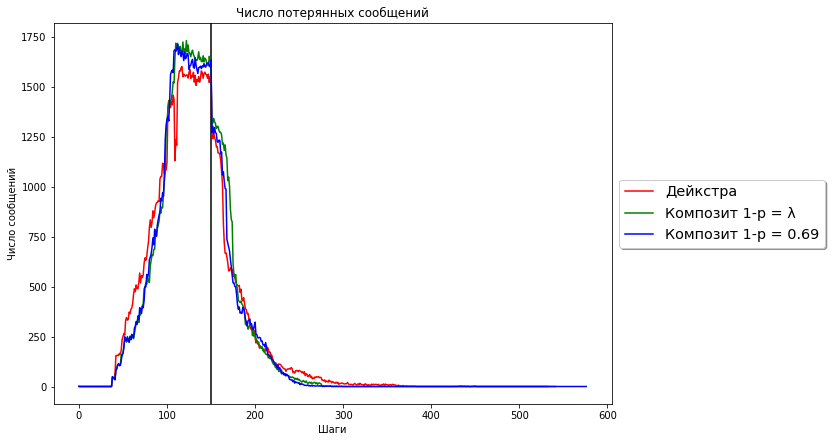

Доставлено 71256 Потеряно 68.3308% -Дейкстра
Доставлено 70728 Потеряно 68.5655% -Композит 1-p = λ
Доставлено 74553 Потеряно 66.8655% -Композит 1-p = 0.69


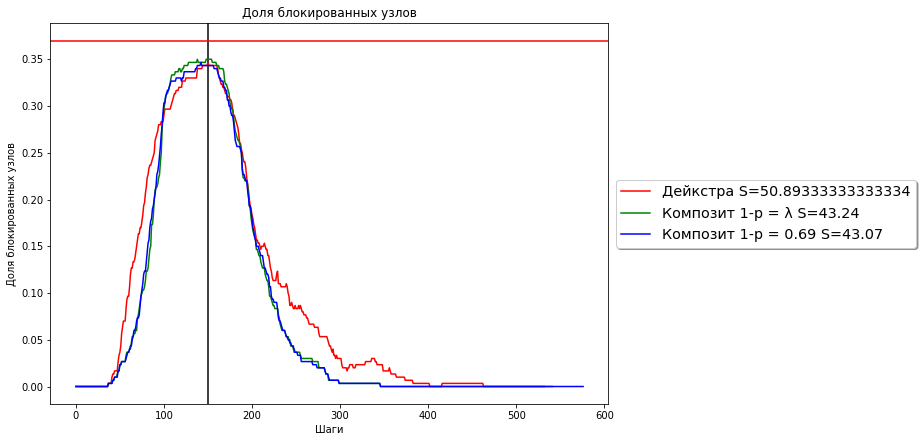

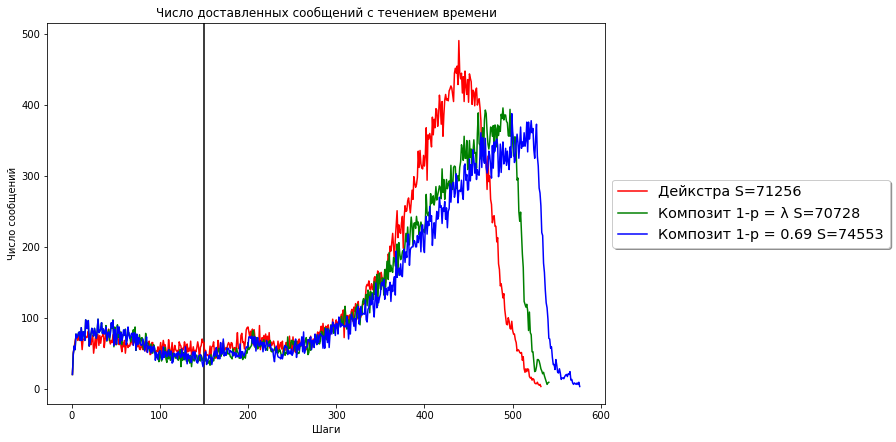

In [5]:
log_tags = [
 {"tag":  "134ad002-857e-469d-8c92-fc67df43072a", "label": "Дейкстра", "color": "red"},
 #{"tag":  "e0ca3ab2-a902-4b06-96b9-db892dc1bc99", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "dc48d0e0-f22c-4550-b684-3e0d3580684f", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "855eb1d9-780d-434c-983d-9c95b6fcdb61", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 45001 Потеряно 0.0000% -Дейкстра
Доставлено 44811 Потеряно 0.4222% -Композит 1-p = λ
Доставлено 44807 Потеряно 0.4311% -Композит 1-p = 0.69


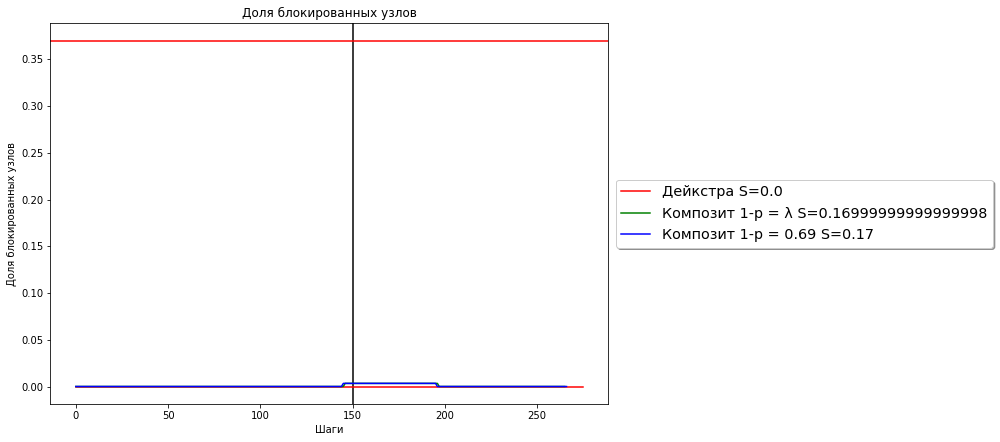

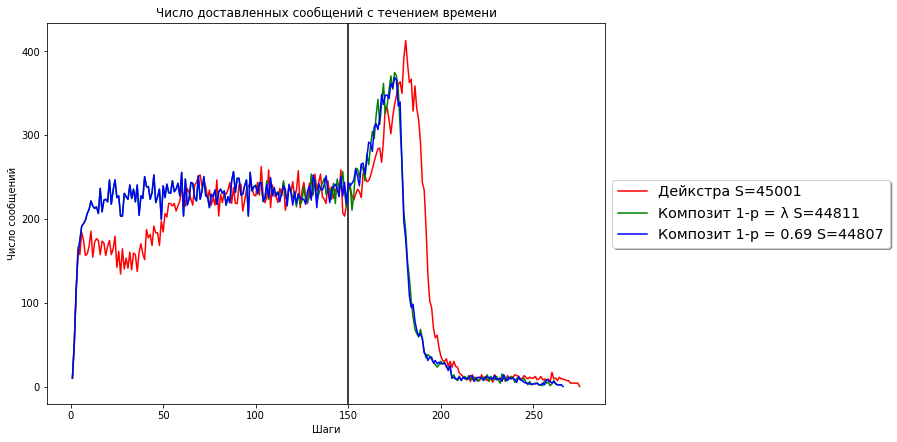

Доставлено 80731 Потеряно 23.1141% -Дейкстра
Доставлено 94526 Потеряно 9.9761% -Композит 1-p = λ
Доставлено 94691 Потеряно 9.8190% -Композит 1-p = 0.69


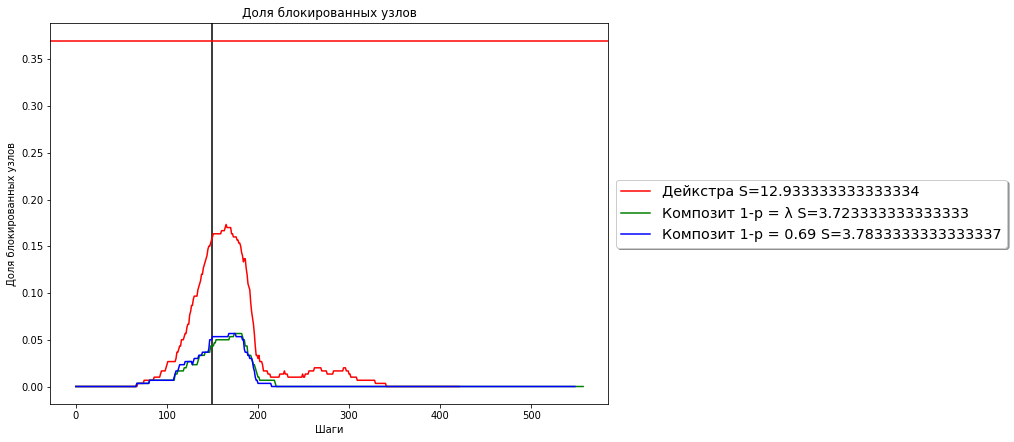

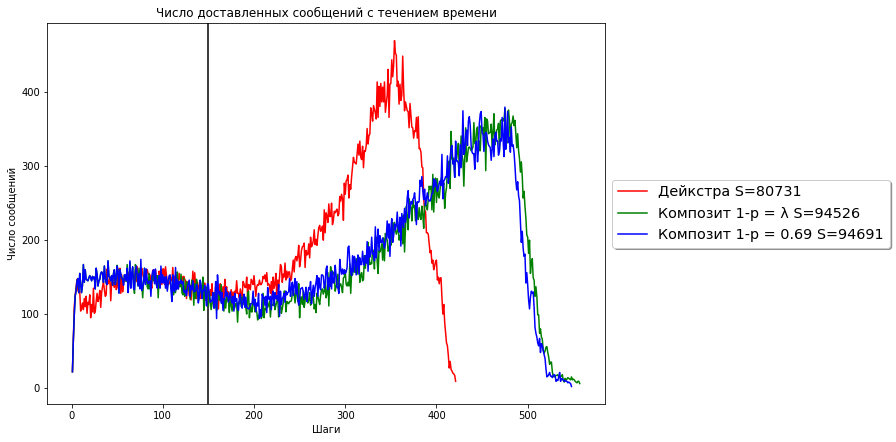

Доставлено 76337 Потеряно 43.4545% -Дейкстра
Доставлено 84855 Потеряно 37.1449% -Композит 1-p = λ
Доставлено 86016 Потеряно 36.2849% -Композит 1-p = 0.69


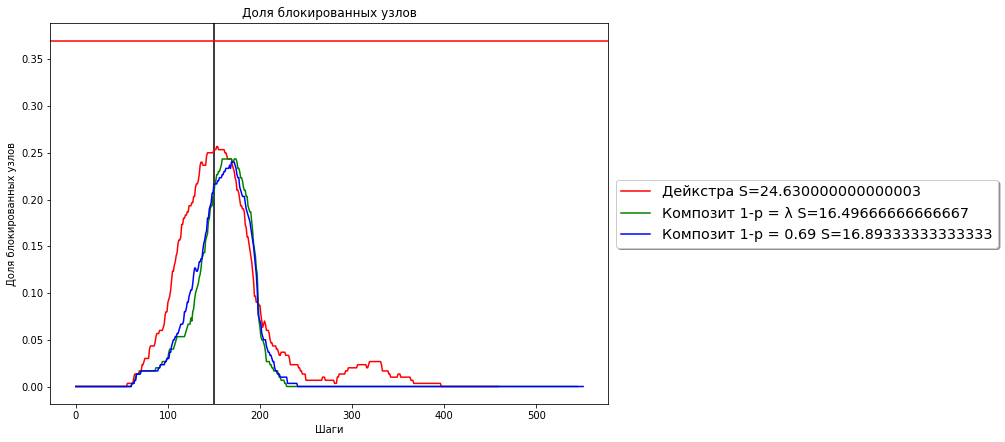

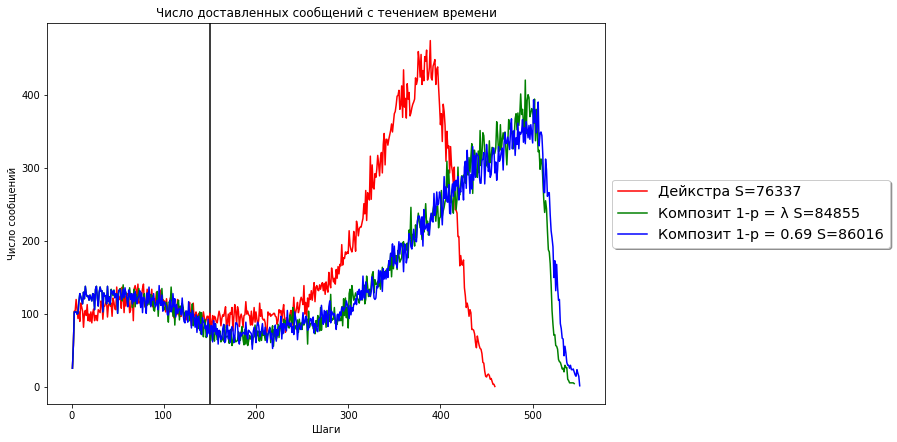

Доставлено 71384 Потеряно 63.3930% -Дейкстра
Доставлено 77910 Потеряно 60.0464% -Композит 1-p = λ
Доставлено 73811 Потеряно 62.1484% -Композит 1-p = 0.69


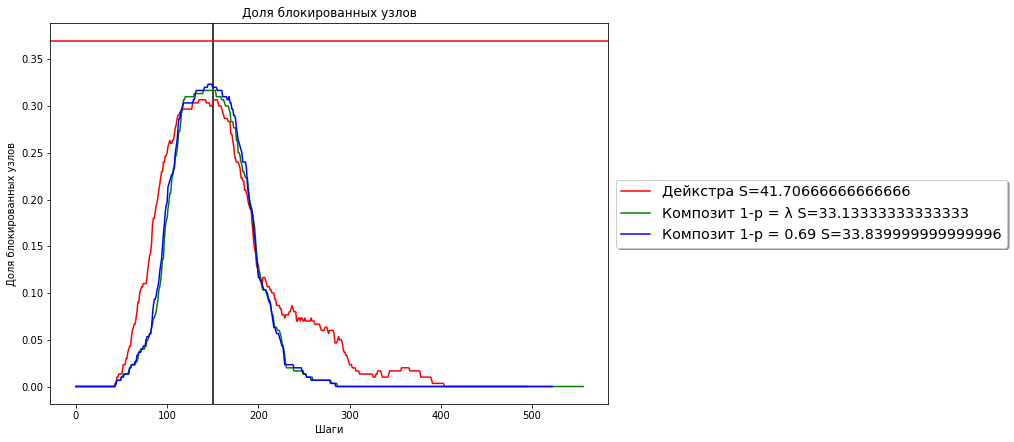

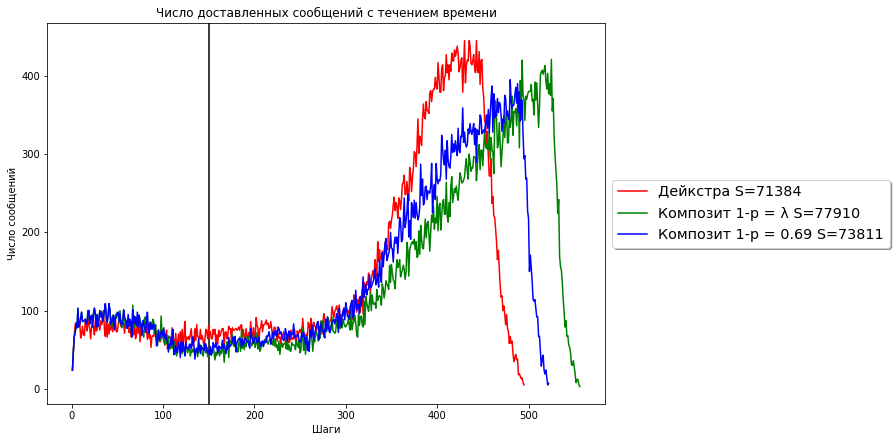

In [6]:
quantity = 300;  
log_tags = [
 {"tag":  "a165bae7-e8d8-4a2f-8352-1f2829f2f39c", "label": "Дейкстра", "color": "red"},
 {"tag":  "43bb2966-92db-4c38-bc42-dbe543d8bef5", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "0a4d4560-d267-4488-8deb-90e0140f3a40", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "b4affa91-0488-496e-981d-e8b11b94bfa4", "label": "Дейкстра", "color": "red"},
 {"tag":  "42c6e35d-b77a-435b-be4b-87e74f7e1207", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "bc487203-79ba-474d-8e9a-f1da6395b483", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "7d51f917-ba42-4c2f-850c-00f31c1244fb", "label": "Дейкстра", "color": "red"},
 {"tag":  "d6cd0b46-5a1d-428d-94fc-e526a7002832", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "8360a932-4490-4d8b-a5b6-3faee4fbdb87", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 1300;  
log_tags = [
 {"tag":  "7149d52d-6daf-4e3b-a836-ebd0a4835e39", "label": "Дейкстра", "color": "red"},
 {"tag":  "c1e08c93-a612-469d-b2bc-90dbc1d7afda", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "7fe706ed-0f7c-4df7-b14f-cae453a70e72", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

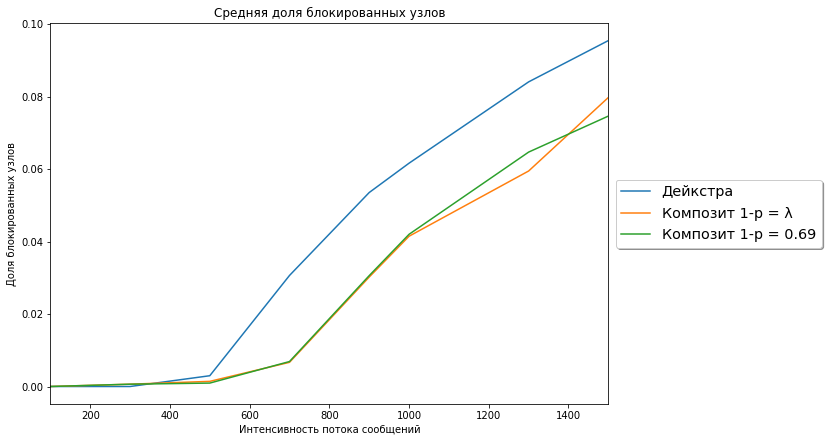

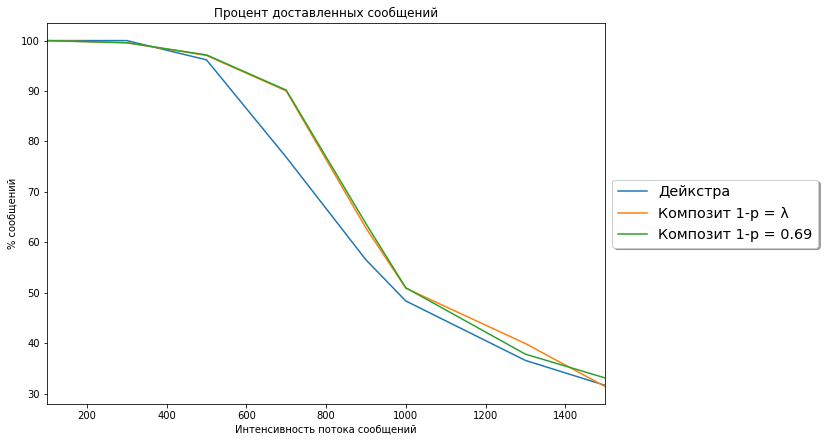

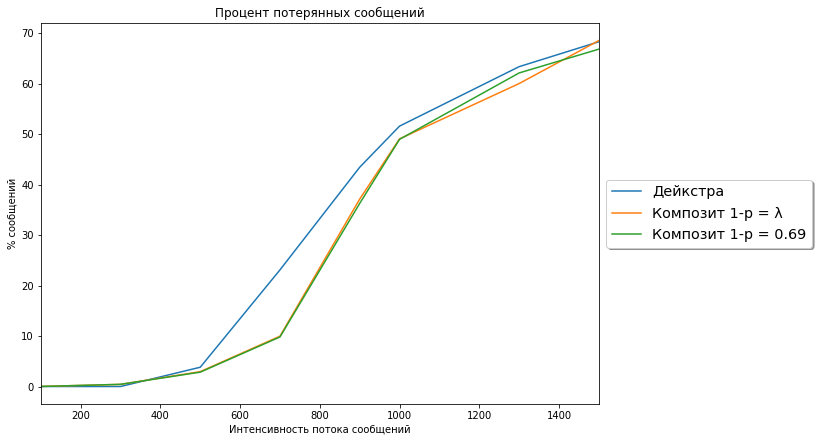

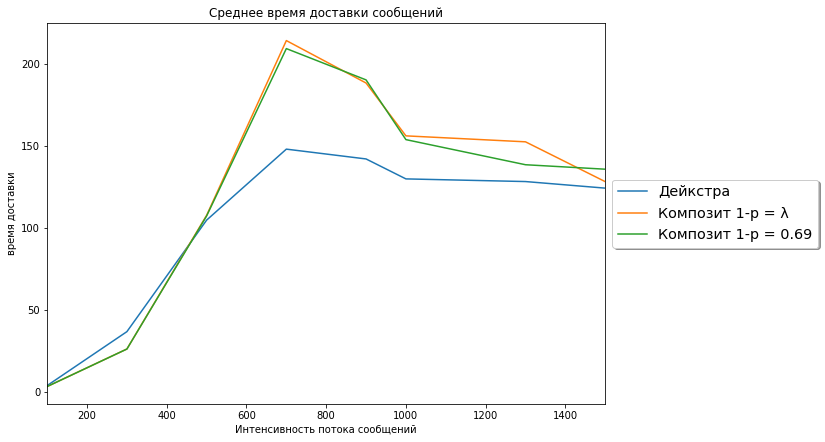

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

Дейкстра               0.041047
Композит 1-p = λ       0.027461
Композит 1-p = 0.69    0.027555

Дейкстра               31.715247
Композит 1-p = λ       28.523835
Композит 1-p = 0.69    28.423644

Дейкстра               102.479039
Композит 1-p = λ       122.329923
Композит 1-p = 0.69    120.816473
